# Cassava Leaf Disease Classification

# 1. Exploratory Data Analysis
Quick Exploratory Data Analysis for [Cassava Leaf Disease Classification challenge](https://www.kaggle.com/c/cassava-leaf-disease-classification/overview)

This competition will challenge you to distinguish between several diseases that cause material harm to the food supply of many African countries. In some cases the main remedy is to burn the infected plants to prevent further spread, which can make a rapid automated turnaround quite useful to the farmers.

## 1.1 Overview

In [3]:
import os
import json

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import cv2
import albumentations as A
from sklearn import metrics as sk_metrics

In [4]:
BASE_DIR = "../data/cassava-leaf-disease/"

In this competition we have 5 classes: **4 diseases** and **1 healthy**
We can find the mapping between the class number and its name in the file `label_num_to_disease_map.json`

In [5]:
with open(os.path.join(BASE_DIR, "label_num_to_disease_map.json")) as file:
    map_classes = json.loads(file.read())
    map_classes = {int(k) : v for k, v in map_classes.items()}
    
print (json.dumps(map_classes, indent=4))

{
    "0": "Cassava Bacterial Blight (CBB)",
    "1": "Cassava Brown Streak Disease (CBSD)",
    "2": "Cassava Green Mottle (CGM)",
    "3": "Cassava Mosaic Disease (CMD)",
    "4": "Healthy"
}


In [6]:
input_files = os.listdir(os.path.join(BASE_DIR, "train_images")) # List of training images
print(f"Number of train images: {len(input_files)}")

Number of train images: 21397


Let's take a look at the dimensions of the first 300 images
As you can see below, all images are the same size (600, 800, 3)

In [8]:
img_shapes = {}
for image_name in os.listdir(os.path.join(BASE_DIR, "train_images"))[:300]:  # first 300 images
    image = cv2.imread(os.path.join(BASE_DIR, "train_images", image_name))
    img_shapes[image.shape] = img_shapes.get(image.shape, 0) + 1
print(img_shapes)

{(600, 800, 3): 300}


Let's load the training dataframe and add a column with the real class name to it.

In [13]:
df_train = pd.read_csv(os.path.join(BASE_DIR, "train.csv"))

df_train["class_name"] = df_train["label"].map(map_classes)

df_train

image_id  label                           class_name
0      1000015157.jpg      0       Cassava Bacterial Blight (CBB)
1      1000201771.jpg      3         Cassava Mosaic Disease (CMD)
2       100042118.jpg      1  Cassava Brown Streak Disease (CBSD)
3      1000723321.jpg      1  Cassava Brown Streak Disease (CBSD)
4      1000812911.jpg      3         Cassava Mosaic Disease (CMD)
...               ...    ...                                  ...
21392   999068805.jpg      3         Cassava Mosaic Disease (CMD)
21393   999329392.jpg      3         Cassava Mosaic Disease (CMD)
21394   999474432.jpg      1  Cassava Brown Streak Disease (CBSD)
21395   999616605.jpg      4                              Healthy
21396   999998473.jpg      4                              Healthy

[21397 rows x 3 columns]

Let's look at the number of pictures in each class.

In [10]:
plt.figure(figsize=(8, 4))
sn.countplot(y="class_name", data=df_train)

<AxesSubplot:xlabel='count', ylabel='class_name'>

As we can see, the dataset has a fairly large **imbalance**.

## 1.2 General Visualization

In [21]:
%matplotlib inline
def visualize_batch(images_ids, labels): # plot grid 3x3 image with labels
    plt.figure(figsize=(16, 12))
    
    for ind, (images_id, label) in enumerate(zip(images_ids, labels)):
        plt.subplot(3, 3, ind +1)
        image = cv2.imread(os.path.join(BASE_DIR, "train_images", images_id))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        plt.imshow(image)
        plt.title(f"Class: {label}", fontsize=12)
        plt.axis("off")
        
    plt.show()

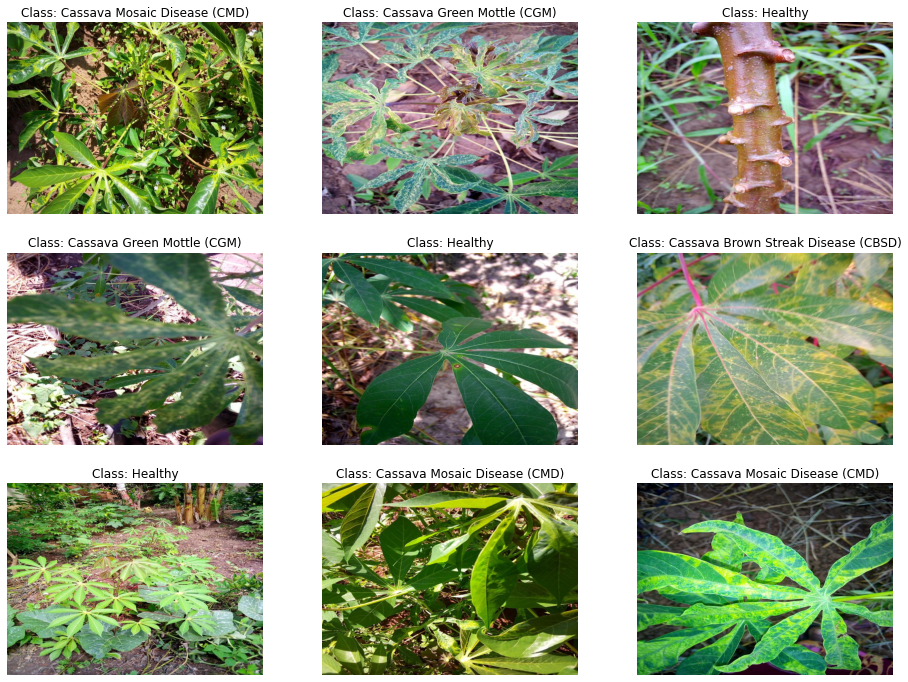

In [22]:
tmp_df = df_train.sample(9)   # get 9 images from data
image_ids = tmp_df["image_id"].values
labels = tmp_df["class_name"].values

visualize_batch(image_ids, labels)

## 1.3 Class 0 - CBB - Cassava Bacterial Blight

![](images/Cassava_Bacterial_Blight.jpg)

Total train images for class 0: 1087


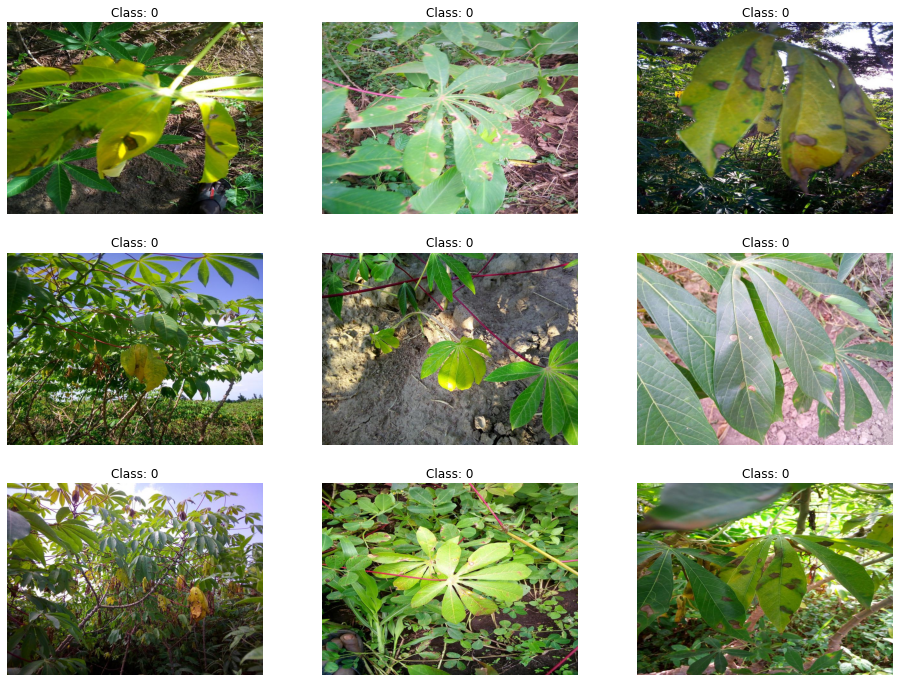

In [23]:
CBB_df = df_train[df_train["label"] ==0]
print(f"Total train images for class 0: {CBB_df.shape[0]}")

CBB_df = CBB_df.sample(9)
image_ids = CBB_df["image_id"].values
labels = CBB_df["label"].values

visualize_batch(image_ids, labels)

## 1.4 Class 1 - CBSD - Cassava Brown Streak Disease

![](images/CBSD.jpeg)

Total train images for class 0: 2189


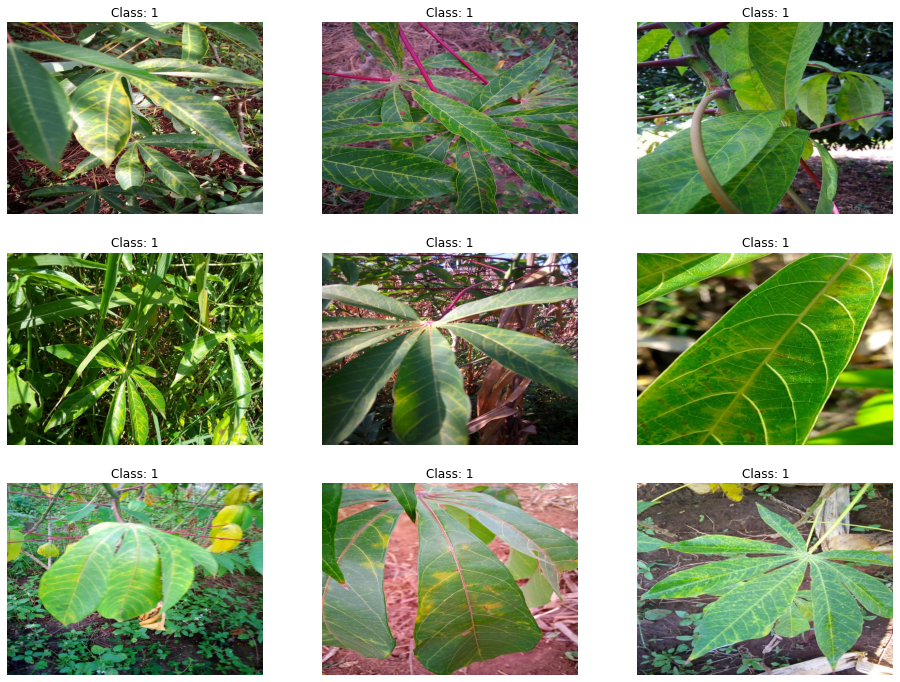

In [25]:
CBSD_df = df_train[df_train["label"] ==1]
print(f"Total train images for class 0: {CBSD_df.shape[0]}")

CBSD_df = CBSD_df.sample(9)
image_ids = CBSD_df["image_id"].values
labels = CBSD_df["label"].values

visualize_batch(image_ids, labels)

## 1.5 Class 2 - CGM - Cassava Green Mottle

![](images/CDM.jpeg)

Total train images for class 2: 2386


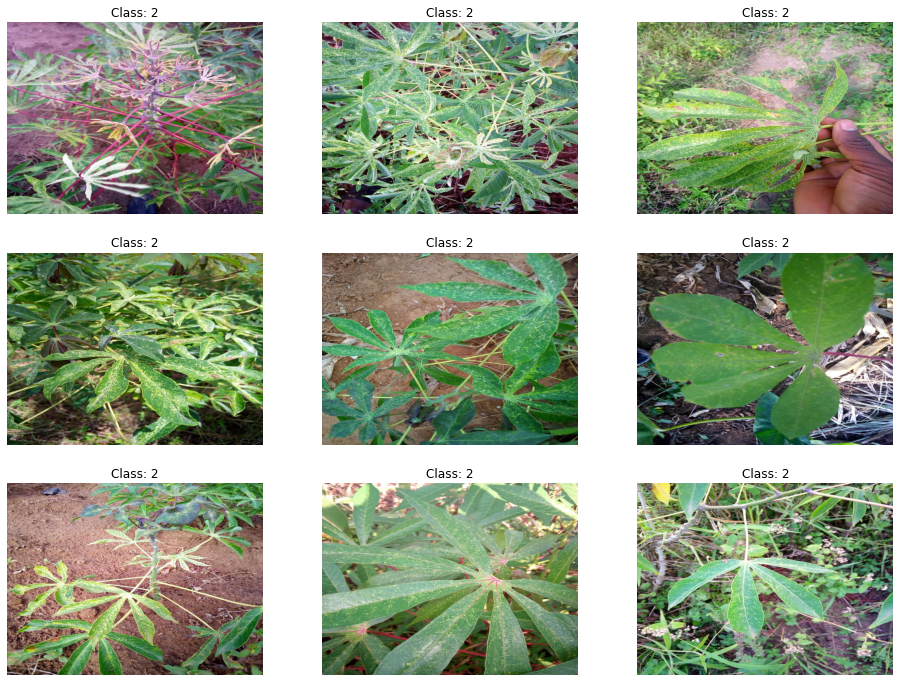

In [26]:
CGM_df = df_train[df_train["label"] == 2]
print(f"Total train images for class 2: {CGM_df.shape[0]}")

CGM_df = CGM_df.sample(9)
image_ids = CGM_df["image_id"].values
labels = CGM_df["label"].values

visualize_batch(image_ids, labels)

## 1.6 Class 3 - CMD - Cassava Mosaic Disease
![](images/CMD.jpeg)

Total train images for class 3: 13158


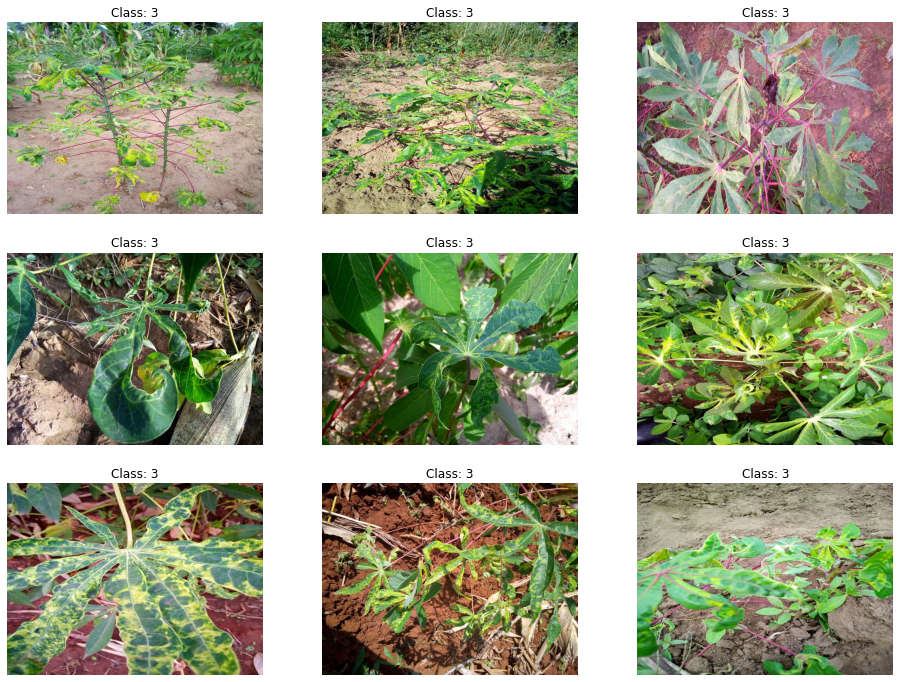

In [27]:
CMD_df = df_train[df_train["label"] == 3]
print(f"Total train images for class 3: {CMD_df.shape[0]}")

CMD_df = CMD_df.sample(9)
image_ids = CMD_df["image_id"].values
labels = CMD_df["label"].values

visualize_batch(image_ids, labels)

## 1.7 Class 4 - Healthy

Total train images for class 4: 2577


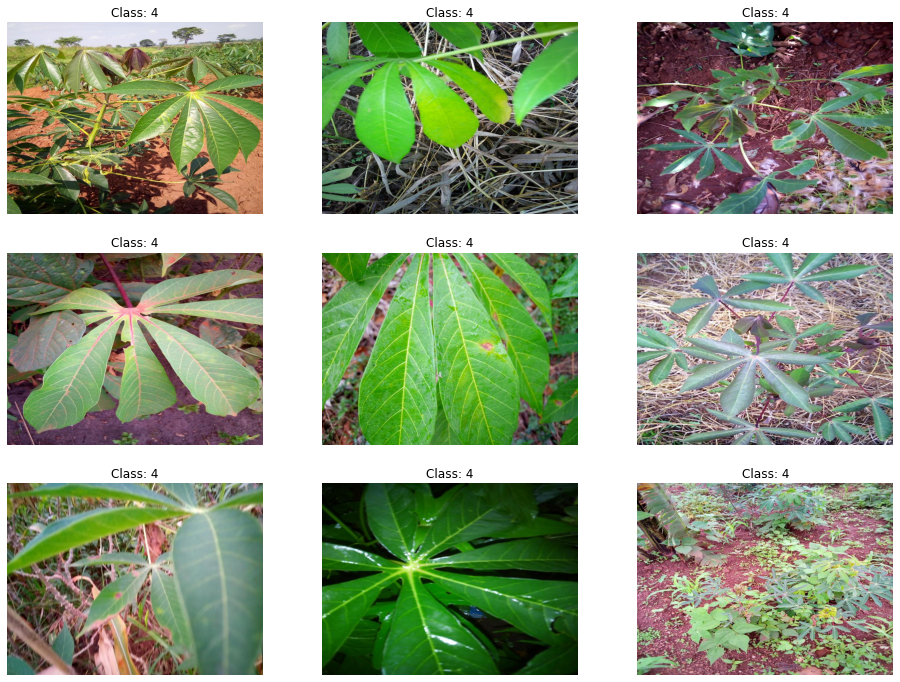

In [28]:
tmp_df = df_train[df_train["label"] == 4]
print(f"Total train images for class 4: {tmp_df.shape[0]}")

tmp_df = tmp_df.sample(9)
image_ids = tmp_df["image_id"].values
labels = tmp_df["label"].values

visualize_batch(image_ids, labels)

# 2. Dataset and Augmentation

## 2.1 Importing Libraries

In [1]:
from __future__ import print_function, division
import random
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision import models as tvmodels
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from tqdm import tqdm
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

import albumentations as A
import numpy as np
import cv2
from sklearn.model_selection import GroupKFold, StratifiedKFold
from efficientnet_pytorch import EfficientNet
from albumentations import Compose
from albumentations.pytorch import ToTensorV2

In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
DATA_PATH = '../data/cassava-leaf-disease/'
NUM_FOLDS = 5
bs = 32
# Running only 5 epochs to test (Train more offline ^_^)
EPOCHS = 10
sz = 512
SNAPMIX_ALPHA = 5.0
SNAPMIX_PCT = 0.5
GRAD_ACCUM_STEPS = 1
TIMM_MODEL = 'efficientnet-b4'

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

SEED = 1234
seed_everything(SEED)

## 2.2 Cassava Dataset

In [5]:
class CassavaDataset(Dataset):
    """Cassava dataset."""

    def __init__(self, dataframe, root_dir, transforms=None):
        """
        Args:
            dataframe (string): dataframe train/valid
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        super().__init__()
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.dataframe)
    
    def get_img_bgr_to_rgb(self, path):
        im_bgr = cv2.imread(path)
        im_rgb = im_bgr[:, :, ::-1]
        return im_rgb

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = os.path.join(self.root_dir,
                                self.dataframe.iloc[idx, 0])
        image = self.get_img_bgr_to_rgb(img_name)
        if self.transforms:
            image = self.transforms(image=image)['image']
        csv_row = self.dataframe.iloc[idx, 1:]
        sample = {
            'image': image, 
            'label': csv_row.label,
        }
        return sample
    
train_df = pd.read_csv(DATA_PATH + "train.csv")

## 2.3 Transforms using albumentations

In [6]:
def train_transforms():
    return Compose([
            A.RandomResizedCrop(sz, sz),
            #A.Transpose(p=0.5),
            A.HorizontalFlip(p=0.5),
            #A.VerticalFlip(p=0.5),
            #A.ShiftScaleRotate(p=0.5),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)


def valid_transforms():
    return Compose([
            A.Resize(sz, sz),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)

## 2.4 Model (modified to support SnapMix)

In [7]:
class CassavaNet(nn.Module):
    def __init__(self):
        super().__init__()
        backbone = EfficientNet.from_pretrained('efficientnet-b4')
        n_features = backbone._fc.in_features
        self.backbone = nn.Sequential(*[
            backbone._conv_stem,
            backbone._bn0,
            nn.Sequential(*backbone._blocks.children()),
            backbone._conv_head,
            backbone._bn1
        ])
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(n_features, 5)


    def forward_features(self, x):
        x = self.backbone(x)
        return x

    def forward(self, x):
        feats = self.forward_features(x)
        x = self.pool(feats).view(x.size(0), -1)
        x = self.classifier(x)
        return x, feats

**Metrics and Check point**

In [8]:
def accuracy_metric(input, targs):
    return accuracy_score(targs.cpu(), input.cpu())

def print_scores(scores):
    kaggle_metric = np.average(scores)
    print("Kaggle Metric: %f" % (kaggle_metric))
    
    return kaggle_metric

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
def checkpoint(model, optimizer, epoch, current_metric, best_metric, fold):
    print("Metric improved from %f to %f , Saving Model at Epoch #%d" % (best_metric, current_metric, epoch))
    ckpt = {
        'model': CassavaNet(),
        'state_dict': model.state_dict(),
        #'optimizer' : optimizer.state_dict(),  # Commenting this out to cheap out on space
        'metric': current_metric
    }
    torch.save(ckpt, 'ckpt_%s-%d-%d.pth' % (TIMM_MODEL, sz, fold))

## 2.5 Create folds

In [10]:
folds = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, 
                        random_state=SEED).split(np.arange(train_df.shape[0]), 
                                                 train_df.label.values)

## 2.6 [SnapMix Augmentation]((https://github.com/Shaoli-Huang/SnapMix))

![](https://raw.githubusercontent.com/Shaoli-Huang/SnapMix/main/imgs/overview.jpg)

In [11]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def get_spm(input,target,model):
    imgsize = (sz, sz)
    bs = input.size(0)
    with torch.no_grad():
        output,fms = model(input)
        clsw = model.classifier
        weight = clsw.weight.data
        bias = clsw.bias.data
        weight = weight.view(weight.size(0),weight.size(1),1,1)
        fms = F.relu(fms)
        poolfea = F.adaptive_avg_pool2d(fms,(1,1)).squeeze()
        clslogit = F.softmax(clsw.forward(poolfea))
        logitlist = []
        for i in range(bs):
            logitlist.append(clslogit[i,target[i]])
        clslogit = torch.stack(logitlist)

        out = F.conv2d(fms, weight, bias=bias)

        outmaps = []
        for i in range(bs):
            evimap = out[i,target[i]]
            outmaps.append(evimap)

        outmaps = torch.stack(outmaps)
        if imgsize is not None:
            outmaps = outmaps.view(outmaps.size(0),1,outmaps.size(1),outmaps.size(2))
            outmaps = F.interpolate(outmaps,imgsize,mode='bilinear',align_corners=False)

        outmaps = outmaps.squeeze()

        for i in range(bs):
            outmaps[i] -= outmaps[i].min()
            outmaps[i] /= outmaps[i].sum()


    return outmaps,clslogit


def snapmix(input, target, alpha, model=None):

    r = np.random.rand(1)
    lam_a = torch.ones(input.size(0))
    lam_b = 1 - lam_a
    target_b = target.clone()

    if True:
        wfmaps,_ = get_spm(input, target, model)
        bs = input.size(0)
        lam = np.random.beta(alpha, alpha)
        lam1 = np.random.beta(alpha, alpha)
        rand_index = torch.randperm(bs).cuda()
        wfmaps_b = wfmaps[rand_index,:,:]
        target_b = target[rand_index]

        same_label = target == target_b
        bbx1, bby1, bbx2, bby2 = rand_bbox(input.size(), lam)
        bbx1_1, bby1_1, bbx2_1, bby2_1 = rand_bbox(input.size(), lam1)

        area = (bby2-bby1)*(bbx2-bbx1)
        area1 = (bby2_1-bby1_1)*(bbx2_1-bbx1_1)

        if  area1 > 0 and  area>0:
            ncont = input[rand_index, :, bbx1_1:bbx2_1, bby1_1:bby2_1].clone()
            ncont = F.interpolate(ncont, size=(bbx2-bbx1,bby2-bby1), mode='bilinear', align_corners=True)
            input[:, :, bbx1:bbx2, bby1:bby2] = ncont
            lam_a = 1 - wfmaps[:,bbx1:bbx2,bby1:bby2].sum(2).sum(1)/(wfmaps.sum(2).sum(1)+1e-8)
            lam_b = wfmaps_b[:,bbx1_1:bbx2_1,bby1_1:bby2_1].sum(2).sum(1)/(wfmaps_b.sum(2).sum(1)+1e-8)
            tmp = lam_a.clone()
            lam_a[same_label] += lam_b[same_label]
            lam_b[same_label] += tmp[same_label]
            lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (input.size()[-1] * input.size()[-2]))
            lam_a[torch.isnan(lam_a)] = lam
            lam_b[torch.isnan(lam_b)] = 1-lam

    return input,target,target_b,lam_a.cuda(),lam_b.cuda()

## 2.7 SnapMix Criterion (Loss)

In [12]:
class SnapMixLoss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, criterion, outputs, ya, yb, lam_a, lam_b):
        loss_a = criterion(outputs, ya)
        loss_b = criterion(outputs, yb)
        loss = torch.mean(loss_a * lam_a + loss_b * lam_b)
        return loss

# 3. Train & Validate

In [ ]:
for fold_num, (train_split, valid_split) in enumerate(folds):
    train_set = train_df.iloc[train_split].reset_index(drop=True)
    valid_set = train_df.iloc[valid_split].reset_index(drop=True)
    
    train_ds = CassavaDataset(dataframe=train_set,
                          root_dir=DATA_PATH + 'train_images',
                          transforms=train_transforms())
    
    valid_ds = CassavaDataset(dataframe=valid_set,
                          root_dir=DATA_PATH + 'train_images',
                          transforms=valid_transforms())
    
    train_dl = torch.utils.data.DataLoader(train_ds, batch_size=bs, 
                                           shuffle=True, num_workers=8, drop_last=True,
                                           pin_memory=True)
    valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=bs, 
                                           shuffle=False, num_workers=8, 
                                           pin_memory=True)
    
    losses = []
    batches = len(train_dl)
    val_batches = len(valid_dl)
    best_metric = 0
    
    model = CassavaNet().to(device)
    criterion = nn.CrossEntropyLoss(reduction='none').to(device)
    val_criterion = nn.CrossEntropyLoss().to(device)
    snapmix_criterion = SnapMixLoss().to(device)
    param_groups = [
       {'params': model.backbone.parameters(), 'lr': 1e-2},
       {'params': model.classifier.parameters()},
    ]
    optimizer = torch.optim.SGD(param_groups, lr=1e-1, momentum=0.9,
                                weight_decay=1e-4, nesterov=True)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1,20,40], 
                                                     gamma=0.1, last_epoch=-1)#, verbose=True)
    scaler = GradScaler()
    
    for epoch in range(EPOCHS):
        # ----------------- TRAINING  ----------------- 
        train_loss = 0
        progress = tqdm(enumerate(train_dl), desc="Loss: ", total=batches)

        model.train()
        for i, data in progress:
            image, label = data.values()
            X, y = image.to(device).float(), label.to(device).long()
            
            with autocast():
                
                rand = np.random.rand()
                if rand > (1.0-SNAPMIX_PCT):
                    X, ya, yb, lam_a, lam_b = snapmix(X, y, SNAPMIX_ALPHA, model)
                    outputs, _ = model(X)
                    loss = snapmix_criterion(criterion, outputs, ya, yb, lam_a, lam_b)
                else:
                    outputs, _ = model(X)
                    loss = torch.mean(criterion(outputs, y))
                
            scaler.scale(loss).backward()
            # Accumulate gradients
            if ((i + 1) % GRAD_ACCUM_STEPS == 0) or ((i + 1) == len(train_dl)):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            train_loss += loss.item()
            cur_step = i+1
            trn_epoch_result = dict()
            trn_epoch_result['Epoch'] = epoch + 1
            trn_epoch_result['train_loss'] = round(train_loss/cur_step, 4)

            progress.set_description(str(trn_epoch_result))

        scheduler.step()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        # ----------------- VALIDATION  ----------------- 
        val_loss = 0
        scores = []

        model.eval()
        with torch.no_grad():
            for i, data in enumerate(valid_dl):
                image, label = data.values()
                X, y = image.to(device), label.to(device)
                outputs, _ = model(X)
                l = val_criterion(outputs, y)
                val_loss += l.item()

                preds = F.softmax(outputs).argmax(axis=1)
                scores.append(accuracy_metric(preds, y))

        epoch_result = dict()
        epoch_result['Epoch'] = epoch + 1
        epoch_result['train_loss'] = round(train_loss/batches, 4)
        epoch_result['val_loss'] = round(val_loss/val_batches, 4)

        print(epoch_result)

        # Check if we need to save
        current_metric = print_scores(scores)
        if current_metric > best_metric:
            checkpoint(model, optimizer, epoch+1, current_metric, best_metric, fold_num)
            best_metric = current_metric
            
    del model, optimizer, train_dl, valid_dl, scaler, scheduler
    torch.cuda.empty_cache()
    
    # Train only a single fold
    break

Loaded pretrained weights for efficientnet-b4
